In [ ]:
%%capture
!pip install diffusers["torch"] transformers

In [1]:
#Load the model and schedulers
from diffusers import DDPMScheduler, UNet2DModel
checkpoint="google/ddpm-cat-256"
scheduler = DDPMScheduler.from_pretrained(checkpoint)
model = UNet2DModel.from_pretrained(checkpoint).to("cuda")

#set the number of timesteps to run the denoising process for
scheduler.set_timesteps(50)



In [2]:
scheduler.timesteps

tensor([980, 960, 940, 920, 900, 880, 860, 840, 820, 800, 780, 760, 740, 720,
        700, 680, 660, 640, 620, 600, 580, 560, 540, 520, 500, 480, 460, 440,
        420, 400, 380, 360, 340, 320, 300, 280, 260, 240, 220, 200, 180, 160,
        140, 120, 100,  80,  60,  40,  20,   0])

In [3]:
model.config

FrozenDict([('sample_size', 256),
            ('in_channels', 3),
            ('out_channels', 3),
            ('center_input_sample', False),
            ('time_embedding_type', 'positional'),
            ('time_embedding_dim', None),
            ('freq_shift', 1),
            ('flip_sin_to_cos', False),
            ('down_block_types',
             ['DownBlock2D',
              'DownBlock2D',
              'DownBlock2D',
              'DownBlock2D',
              'AttnDownBlock2D',
              'DownBlock2D']),
            ('up_block_types',
             ['UpBlock2D',
              'AttnUpBlock2D',
              'UpBlock2D',
              'UpBlock2D',
              'UpBlock2D',
              'UpBlock2D']),
            ('block_out_channels', [128, 128, 256, 256, 512, 512]),
            ('layers_per_block', 2),
            ('mid_block_scale_factor', 1),
            ('downsample_padding', 0),
            ('downsample_type', 'conv'),
            ('upsample_type', 'conv'),
            ('

In [4]:
#create random noise
import torch
sample_size = model.config.sample_size
noise = torch.randn((1, 3, sample_size, sample_size)).to("cuda")

In [5]:
noise.shape

torch.Size([1, 3, 256, 256])

In [ ]:
#noise.to("cuda")

create a loop: model gives out noise residual, noise residual fed into scheduler. scheduler.step() gives out denoised previous image
which is put into the loop again

In [6]:
input = noise

for t in scheduler.timesteps:
    #noise residual
    with torch.no_grad():
        noisy_residual = model(input, t).sample
    #denoise
    previous_noisy_sample = scheduler.step(model_output=noisy_residual, timestep=t, sample=input).prev_sample
    
    input = previous_noisy_sample

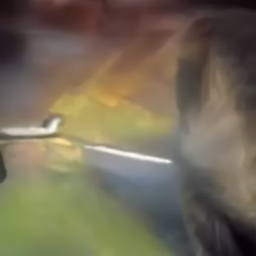

In [7]:
from PIL import Image
import numpy as np

image = (input / 2 + 0.5).clamp(0, 1)
image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
image = Image.fromarray((image * 255).round().astype("uint8"))
image

## Deconstruct stable diffusion

In [8]:
from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

checkpoint = "CompVis/stable-diffusion-v1-4"

In [9]:
vae = AutoencoderKL.from_pretrained(checkpoint, subfolder="vae")
model = UNet2DConditionModel.from_pretrained(checkpoint, subfolder="unet")
tokenizer = CLIPTokenizer.from_pretrained(checkpoint, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(checkpoint, subfolder="text_encoder")

In [10]:
from diffusers import UniPCMultistepScheduler
shecduler = UniPCMultistepScheduler.from_pretrained(checkpoint, subfolder="scheduler")

In [11]:
device="cuda"
vae.to(device)
text_encoder.to(device)
model.to(device)

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

### Create text embeddings

In [12]:
prompt = ["a cat is playing football wearing the Argentina jersey of Messi"]
height = 512
width = 512
num_inference_steps = 25
guidance_scale = 7.5
generator = torch.manual_seed(0)
batch_size = len(prompt)

In [13]:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

In [14]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

In [15]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

## Create Random Noise

In [16]:
model.in_channels

/tmp/ipykernel_1144/651927568.py:1: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  model.in_channels


4

In [17]:
model.config.in_channels

4

In [18]:
#why divided by 8:  vae model has 3 down-sampling layers.
2 ** (len(vae.config.block_out_channels) - 1) == 8

True

In [19]:
latents = torch.randn((batch_size, model.config.in_channels, height//8, width//8), generator=generator)
latents.to(device)

tensor([[[[-1.1258, -1.1524, -0.2506,  ..., -1.2341,  1.8197, -0.5515],
          [-0.5692,  0.9200,  1.1108,  ...,  1.1648,  0.9234,  1.3873],
          [-0.8834, -0.4189, -0.8048,  ..., -0.9944, -1.1894, -1.1959],
          ...,
          [ 0.0859, -0.3592, -2.4972,  ..., -1.0989, -0.2155,  0.3364],
          [ 0.5901, -0.8325, -1.3715,  ...,  1.0564, -0.1504,  0.7420],
          [ 0.7272, -0.2612,  0.0124,  ..., -3.0357, -1.7288,  0.6020]],

         [[ 1.9476,  1.0077, -0.1007,  ..., -0.1173, -0.6841,  0.5988],
          [-0.2579, -1.0667, -0.7595,  ..., -0.1600,  1.0375,  1.2084],
          [ 1.3706, -0.0510,  2.6697,  ...,  0.1930, -2.0206, -0.5840],
          ...,
          [-1.5910,  1.0099,  0.2331,  ..., -0.5705, -0.8428, -1.2050],
          [-1.6555,  0.7469,  1.6022,  ..., -0.8822,  0.3436, -0.3445],
          [-0.0718,  0.8205, -0.0775,  ..., -0.7476, -1.0687, -0.1856]],

         [[ 0.2652, -0.7908,  0.9808,  ...,  0.4130, -0.7824,  1.7467],
          [-0.0583,  0.9223,  

## Denoise the image

In [20]:
scheduler.init_noise_sigma

1.0

In [21]:
#scaling the input with the initial noise distribution, sigma
latents = latents * scheduler.init_noise_sigma

In [22]:
latents.to(device)

tensor([[[[-1.1258, -1.1524, -0.2506,  ..., -1.2341,  1.8197, -0.5515],
          [-0.5692,  0.9200,  1.1108,  ...,  1.1648,  0.9234,  1.3873],
          [-0.8834, -0.4189, -0.8048,  ..., -0.9944, -1.1894, -1.1959],
          ...,
          [ 0.0859, -0.3592, -2.4972,  ..., -1.0989, -0.2155,  0.3364],
          [ 0.5901, -0.8325, -1.3715,  ...,  1.0564, -0.1504,  0.7420],
          [ 0.7272, -0.2612,  0.0124,  ..., -3.0357, -1.7288,  0.6020]],

         [[ 1.9476,  1.0077, -0.1007,  ..., -0.1173, -0.6841,  0.5988],
          [-0.2579, -1.0667, -0.7595,  ..., -0.1600,  1.0375,  1.2084],
          [ 1.3706, -0.0510,  2.6697,  ...,  0.1930, -2.0206, -0.5840],
          ...,
          [-1.5910,  1.0099,  0.2331,  ..., -0.5705, -0.8428, -1.2050],
          [-1.6555,  0.7469,  1.6022,  ..., -0.8822,  0.3436, -0.3445],
          [-0.0718,  0.8205, -0.0775,  ..., -0.7476, -1.0687, -0.1856]],

         [[ 0.2652, -0.7908,  0.9808,  ...,  0.4130, -0.7824,  1.7467],
          [-0.0583,  0.9223,  

In [23]:
text_embeddings.to(device)

tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [-0.3711, -1.4497, -0.3401,  ...,  0.9489,  0.1867, -1.1034],
         [-0.5107, -1.4629, -0.2926,  ...,  1.0419,  0.0701, -1.0284],
         ...,
         [ 0.5006, -0.9552, -0.6610,  ...,  1.6013, -1.0622, -0.2191],
         [ 0.4988, -0.9451, -0.6656,  ...,  1.6467, -1.0858, -0.2088],
         [ 0.4924, -0.8124, -0.4912,  ...,  1.6108, -1.0174, -0.2484]],

        [[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.1177,  0.9112,  0.6360,  ..., -3.0963,  0.0562, -0.0659],
         ...,
         [-0.5738, -0.8393,  1.1443,  ..., -0.8153, -0.4790, -0.4865],
         [-0.5407, -0.8217,  1.1480,  ..., -0.8287, -0.4817, -0.4856],
         [-0.6008, -0.7662,  1.1341,  ..., -0.7255, -0.4227, -0.4485]]],
       device='cuda:0', grad_fn=<CatBackward0>)

In [24]:
%%capture
model.to(device)

In [25]:
model.config

FrozenDict([('sample_size', 64),
            ('in_channels', 4),
            ('out_channels', 4),
            ('center_input_sample', False),
            ('flip_sin_to_cos', True),
            ('freq_shift', 0),
            ('down_block_types',
             ['CrossAttnDownBlock2D',
              'CrossAttnDownBlock2D',
              'CrossAttnDownBlock2D',
              'DownBlock2D']),
            ('mid_block_type', 'UNetMidBlock2DCrossAttn'),
            ('up_block_types',
             ['UpBlock2D',
              'CrossAttnUpBlock2D',
              'CrossAttnUpBlock2D',
              'CrossAttnUpBlock2D']),
            ('only_cross_attention', False),
            ('block_out_channels', [320, 640, 1280, 1280]),
            ('layers_per_block', 2),
            ('downsample_padding', 1),
            ('mid_block_scale_factor', 1),
            ('dropout', 0.0),
            ('act_fn', 'silu'),
            ('norm_num_groups', 32),
            ('norm_eps', 1e-05),
            ('cross_attenti

In [26]:
from tqdm.auto import tqdm
scheduler.set_timesteps(num_inference_steps)

for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents]*2)
    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)
    
    with torch.no_grad():
        noise_pred = model(latent_model_input.cuda(), t, encoder_hidden_states=text_embeddings).sample
    
    
    #perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1

    latents = scheduler.step(noise_pred.cuda(), t, latents.cuda()).prev_sample

  0%|          | 0/25 [00:00<?, ?it/s]

### Decode Image

In [27]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

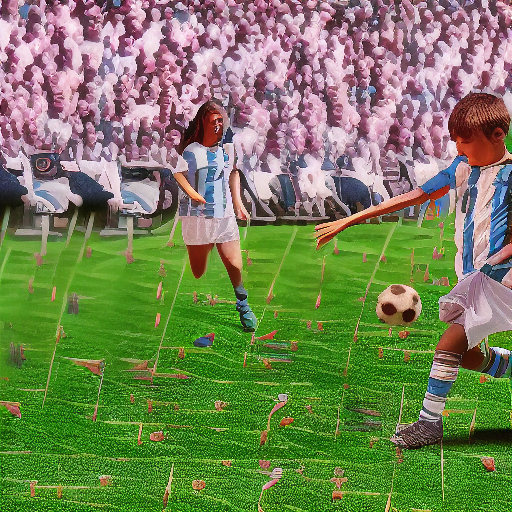

In [28]:
image = (image / 2 + 0.5).clamp(0, 1)

image = image.detach().cpu().permute(0, 2, 3, 1).numpy()

images = (image * 255).round().astype("uint8")

pil_images = [Image.fromarray(image) for image in images]

pil_images[0]

## Training

In [ ]:
%%capture
!pip install dataclass

In [29]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "ddpm-butterflies-128"  # the model name locally and on the HF Hub
    push_to_hub = False  # whether to upload the saved model to the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0


In [30]:
config = TrainingConfig()

In [31]:
from datasets import load_dataset
config.dataset_name = "huggan/few-shot-obama"
dataset = load_dataset(config.dataset_name, split="train")

README.md:   0%|          | 0.00/676 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


dataset_infos.json:   0%|          | 0.00/646 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/100 [00:00<?, ? examples/s]

(256, 256)
(256, 256)
(256, 256)
(256, 256)


/tmp/ipykernel_1144/1898627019.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


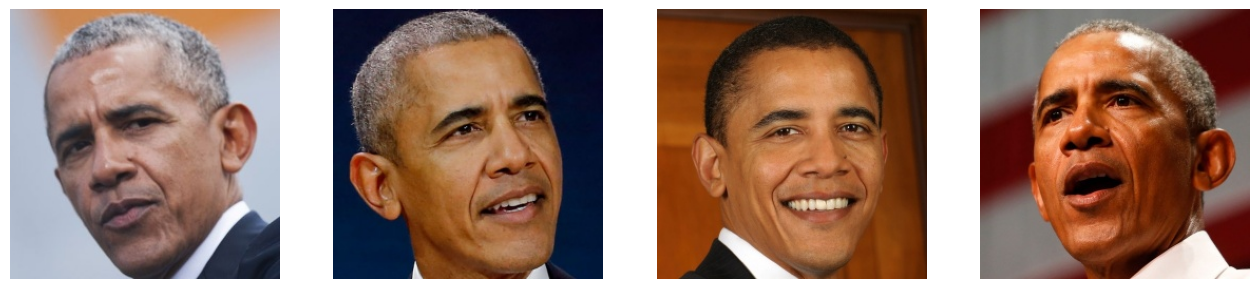

In [33]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
    print(image.size)
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

## Transformation

In [34]:
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5])
    ]
)

In [35]:
def transform(examples):
    images = [preprocess(image.convert("RGB"))  for image in examples["image"]]
    return {"images":images}

In [36]:
dataset.set_transform(transform)

In [37]:
dataset

Dataset({
    features: ['image'],
    num_rows: 100
})

In [38]:
dataset[:1]["images"][0].shape

torch.Size([3, 128, 128])

In [39]:
import torch

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

### Create UNet2DModel

In [40]:
from diffusers import UNet2DModel
model = UNet2DModel(
    sample_size=config.image_size,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(128, 128, 256, 256, 512, 512),
        down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),

    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [41]:
%%capture
!pip install einops

In [42]:
dataset[0]["images"].size()

torch.Size([3, 128, 128])

In [43]:
dataset[0]["images"].unsqueeze(0).size()

torch.Size([1, 3, 128, 128])

In [44]:
import einops

In [45]:
sample_image = dataset[0]["images"]
sample_image = einops.rearrange(sample_image, "c h w -> 1 c h w")
sample_image.shape

torch.Size([1, 3, 128, 128])

In [46]:
model(sample_image, timestep=0).sample.shape

torch.Size([1, 3, 128, 128])

### Create a scheduler

In [47]:
import torch
from PIL import Image
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(original_samples=sample_image, noise=noise, timesteps=timesteps)

In [48]:
noisy_image.shape

torch.Size([1, 3, 128, 128])

In [49]:
#move the channel to the last dim for PIL
x = einops.rearrange(noisy_image, "b c h w -> b h w c")
x.shape

torch.Size([1, 128, 128, 3])

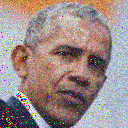

In [50]:
Image.fromarray(((x + 1.0) * 127.5).type(torch.uint8).numpy()[0])

The purpose of training is to predict the noise added to the image

In [51]:
import torch.nn.functional as F
noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)

## Training the model

Define optimizer and learning rate scheduler

In [52]:
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(),lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer = optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

Define model evaluation metric

In [53]:
from diffusers import DDPMPipeline
import math
import os

def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i % cols * w, i // cols * h))
    return grid

In [54]:
def evaluate(config, epoch, pipeline):
    images = pipeline(batch_size=config.eval_batch_size,generator=torch.manual_seed(config.seed),).images
    
    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [55]:
%%capture
! pip install --upgrade accelerate

In [56]:
!pip show accelerate

Name: accelerate
Version: 1.2.1
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: zach.mueller@huggingface.co
License: Apache
Location: /home/ninben/anaconda3/envs/pytorch_test/lib/python3.9/site-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: 


In [57]:
!nvidia-smi

Tue Dec 31 17:14:49 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.02              Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 Ti     On  |   00000000:01:00.0  On |                  N/A |
|  0%   31C    P8             17W /  285W |    7361MiB /  12282MiB |      8%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

#### Training loop

In [58]:
from accelerate import Accelerator
from tqdm.auto import tqdm
from pathlib import Path
import os

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    accelerator = Accelerator(
        mixed_precision = config.mixed_precision,
        gradient_accumulation_steps = config.gradient_accumulation_steps,
        log_with="tensorboard",
        logging_dir=os.path.join(config.output_dir, "logs"),
    )
    
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")
        
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )
    
    global_step = 0
    
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")
        
        for step, batch in enumerate(train_dataloader):
            clean_images = batch["images"]
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            batch_size = clean_images.shape[0]
            
            #sample random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (batch_size,), device=clean_images.device).long()
        
            #add noise to each clean image for each random timestep
            #this is the forward diffusion process
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
            
            with accelerator.accumulate(model):
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)
                
                accelerator.clip_grad_norm_(model.parameters(),1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
                
            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1
            
       # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)
            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                    pipeline.save_pretrained(config.output_dir)
        

In [59]:
from accelerate import notebook_launcher
args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)
notebook_launcher(train_loop, args, num_processes=2)

Launching training on 2 GPUs.


E1231 17:15:01.548187 1144 site-packages/torch/distributed/elastic/multiprocessing/api.py:732] failed (exitcode: 1) local_rank: 0 (pid: 2506) of fn: train_loop (start_method: fork)
E1231 17:15:01.548187 1144 site-packages/torch/distributed/elastic/multiprocessing/api.py:732] Traceback (most recent call last):
E1231 17:15:01.548187 1144 site-packages/torch/distributed/elastic/multiprocessing/api.py:732]   File "/home/ninben/anaconda3/envs/pytorch_test/lib/python3.9/site-packages/torch/distributed/elastic/multiprocessing/api.py", line 687, in _poll
E1231 17:15:01.548187 1144 site-packages/torch/distributed/elastic/multiprocessing/api.py:732]     self._pc.join(-1)
E1231 17:15:01.548187 1144 site-packages/torch/distributed/elastic/multiprocessing/api.py:732]   File "/home/ninben/anaconda3/envs/pytorch_test/lib/python3.9/site-packages/torch/multiprocessing/spawn.py", line 203, in join
E1231 17:15:01.548187 1144 site-packages/torch/distributed/elastic/multiprocessing/api.py:732]     raise Pr

ChildFailedError: 
============================================================
train_loop FAILED
------------------------------------------------------------
Failures:
  <NO_OTHER_FAILURES>
------------------------------------------------------------
Root Cause (first observed failure):
[0]:
  time      : 2024-12-31_17:15:01
  host      : DESKTOP-PUI9QMD.
  rank      : 0 (local_rank: 0)
  exitcode  : 1 (pid: 2506)
  error_file: /tmp/torchelastic_ja9xsj3w/none_byqyonop/attempt_0/0/error.json
  traceback : Traceback (most recent call last):
    File "/home/ninben/anaconda3/envs/pytorch_test/lib/python3.9/site-packages/torch/distributed/elastic/multiprocessing/errors/__init__.py", line 355, in wrapper
      return f(*args, **kwargs)
    File "/tmp/ipykernel_1144/2933907931.py", line 7, in train_loop
      accelerator = Accelerator(
  TypeError: __init__() got an unexpected keyword argument 'logging_dir'
  
============================================================